In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
from numba import jit, njit, prange
from quantecon.util import tic, toc

In [2]:
@njit
def u(c):
    return np.log(c)

In [3]:
class AiyagariProb:
    
    def __init__(self,
                 r=0.01,                      # interest rate
                 w=1.0,                       # wages
                 cbeta=0.96,                  # discount factor
                 a_min=1e-10,
                 P=[[0.9, 0.1], [0.1, 0.9]],  # Markov chain
                 z_vals=[0.1, 1.0],           # exogenous states
                 a_max=18,
                 a_size=200
                 ):
        
        #making all options class objects
        self.r, self.w, self.cbeta = r, w, cbeta 
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size
        self.P, self.z_vals = np.asarray(P), np.asarray(z_vals)
        self.z_size = len(z_vals)
        
        self.a_grid = np.linspace(a_min, a_max, a_size)
    
    def pack_params(self):
        return self.r, self.w, self.cbeta, self.a_min, self.a_max, self.a_size, self.P, self.z_vals, self.a_grid
        
    def bellman_operator(self):
        
        r, w, cbeta, a_min, a_max, a_size, P, z_vals, a_grid = self.pack_params()
        
        @njit
        def T(v, v_out, pol):
            n, m = v.shape

            for j in prange(m):
                z = z_vals[j]

                for i in range(n):
                    x = a_grid[i]
                    # Cash in hand at start of period
                    y = (1.0 + r) * x + w * z
                    max_so_far = - np.inf
                    # Find largest x_grid index s.t. x' <= y
                    idx = np.searchsorted(a_grid, y)
                    # Step through x' with 0 <= x' <= y, find max
                    for k in range(idx):
                        x_next = a_grid[k]
                        val = u(y - x_next) + cbeta * np.sum(v[k, :] * P[j, :])
                        if val > max_so_far:
                            max_so_far = val
                            a_star = k

                    pol[i, j] = a_star
                    v_out[i, j] = max_so_far

        return T

In [43]:
def value_function_iteration(T, 
                             v_init,
                             tol=1e-4, 
                             max_iter=1000, 
                             verbose=True,
                             print_skip=25):

    # Set initial condition, set up storage
    v_in = v_init
    v_out = np.empty_like(v_in)
    pol = np.empty_like(v_in, dtype=np.int)

    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        T(v_in, v_out, pol)
        error = np.max(np.abs(v_in - v_out))
        i += 1
        if i % print_skip == 0:
            print(f"Value Function Calc: Error at iteration {i} is {error}.")
        v_in[:] = v_out

    if i == max_iter: 
        print("Value Function Calc: Failed to converge!")

    if verbose and i < max_iter:
        print(f"Value Function Calc: \nConverged in {i} iterations.")

    return v_out, pol


@njit
def jitted_vfi(T, v_init, tol=1e-4, max_iter=1000):

    # Set initial condition, set up storage
    v_in = v_init
    v_out = np.empty_like(v_in)
    pol = np.empty_like(v_in, dtype=np.int_)
    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        T(v_in, v_out, pol)
        error = np.max(np.abs(v_in - v_out))
        i += 1
        v_in[:] = v_out
    return v_out, pol

In [11]:
mod = AiyagariProb()
T = mod.bellman_operator()
v_init = np.ones((mod.a_size, mod.z_size))

In [12]:
tic()
v_star, pol = value_function_iteration(T, v_init)
toc()

Error at iteration 25 is 0.36220107656560074.
Error at iteration 50 is 0.12418447363760521.
Error at iteration 75 is 0.044534594737768884.
Error at iteration 100 is 0.016041160141224253.
Error at iteration 125 is 0.00578080840271511.
Error at iteration 150 is 0.0020833697581821298.
Error at iteration 175 is 0.0007508390474555426.
Error at iteration 200 is 0.0002705999050931496.
Error at iteration 225 is 9.752331649792723e-05.

Converged in 225 iterations.
TOC: Elapsed: 0:00:1.37


1.3772695064544678

In [13]:
@njit(parallel=True)
def simulate_stationary_assets(pol, 
                               P, 
                               a_grid, 
                               i_init=10, 
                               j_init=0, 
                               num_households=100_000,
                               ts_length=1000):
    asset_vals = np.empty(num_households)
    for m in prange(num_households):
        i = i_init
        j = j_init

        for t in range(ts_length-1):
            i = pol[i, j]
            j = qe.random.draw(np.cumsum(P[j, :]))
            
        asset_vals[m] = a_grid[i]
        
    return asset_vals

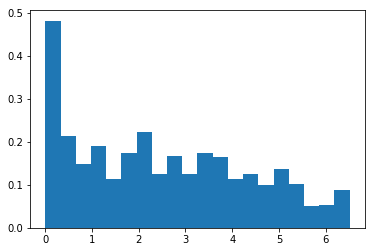

In [22]:
asset_vals = simulate_stationary_assets(pol,mod.P, mod.a_grid)
fig, ax = plt.subplots()
ax.hist(asset_vals, bins=20, density=True)
plt.show()

In [52]:
A = 1.0
N = 1.0
calpha = 0.33
cbeta = 0.96
cdelta = 0.05


def r_to_w(r):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    return A * (1 - calpha) * (A * calpha / (r + cdelta))**(calpha / (1 - calpha))

def rd(K):
    """
    Inverse demand curve for capital.  The interest rate associated with a
    given demand for capital K.
    """
    return A * calpha * (N / K)**(1 - calpha) - cdelta


def prices_to_capital_stock():
    """
    Map prices to the induced level of capital stock.
    
    Parameters:
    ----------
    
    am : Household
        An instance of an aiyagari_household.Household 
    r : float
        The interest rate
    """
    asset_vals = simulate_stationary_assets(pol,mod.P, mod.a_grid)
    return np.mean(asset_vals)


In [54]:

def get_eq(r_min = 0.02, r_max = 0.04, r_size = 100, tol = 1e-3):
    
    r_range = np.linspace(r_min, r_max, r_size)
    iter = 0
    
    for r_i in r_range:
        
        # Figure out firm problem
        w_i = r_to_w(r_i)
        
        # Solve agents problems
        mod = AiyagariProb(r = r_i, w = w_i)
        T = mod.bellman_operator()
        v_init = np.ones((mod.a_size, mod.z_size))
        v_star, pol = jitted_vfi(T, v_init)
        
        k_s = prices_to_capital_stock()
        
        # get back how much the firm is willing to pay for that K_s
        r_star = rd(k_s)
        
        # Error
        error = np.absolute(r_star - r_i)
        
        print(" ")
        print(f"Equilbrium Calc: Error is {error}")
        
        iter += 1
        
        if error < tol:
            
            r_eq = r_star
            k_eq = k_s
            print(f"#################################")
            print(f"Equilibrium Interest Rate: {r_eq}")
            print(f"Equilibrium Capital Stock: {k_eq}")
            print(f"#################################")
            
            break

In [53]:
r_i = 0.03
w_i = r_to_w(r_i)
mod = AiyagariProb(r = r_i, w = w_i)
T = mod.bellman_operator()
v_init = np.ones((mod.a_size, mod.z_size))
v_star, pol = jitted_vfi(T, v_init)

k_s = prices_to_capital_stock()
print(k_s)

7.425451356842669


In [55]:
get_eq()

 
Equilbrium Calc: Error is 0.01604073965443018
 
Equilbrium Calc: Error is 0.015920077016676058
 
Equilbrium Calc: Error is 0.01580353779658946
 
Equilbrium Calc: Error is 0.015258386415438717
 
Equilbrium Calc: Error is 0.015109111911358934
 
Equilbrium Calc: Error is 0.014999204248596989
 
Equilbrium Calc: Error is 0.01476046626254544
 
Equilbrium Calc: Error is 0.014730932627048318
 
Equilbrium Calc: Error is 0.01431465826513817
 
Equilbrium Calc: Error is 0.014400185361964662
 
Equilbrium Calc: Error is 0.014141375822621666
 
Equilbrium Calc: Error is 0.013761564095400986
 
Equilbrium Calc: Error is 0.013600569695030311
 
Equilbrium Calc: Error is 0.013483108296901407
 
Equilbrium Calc: Error is 0.01326654748880201
 
Equilbrium Calc: Error is 0.012997642138626957
 
Equilbrium Calc: Error is 0.012786363790431157
 
Equilbrium Calc: Error is 0.012402516708762853
 
Equilbrium Calc: Error is 0.012409235659797624
 
Equilbrium Calc: Error is 0.012385283929486443
 
Equilbrium Calc: Error 

KeyboardInterrupt: 